# RSI Trading Strategy
 
Build a trading algo using rsi indicator.  
RSI(Relative Strength Index) indicator evaluates overbought or oversold conditions of a stock.  
Serves as a baseline before adding deep learning models to try to improve the strategy's performance

Run stategy on intraday time scale and RSI of 5 periods

Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import tensorflow as tf

Load intraday data from intraday_data.py

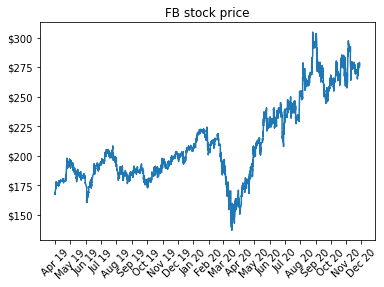

In [11]:
df = pd.read_csv('FB_raw.csv')
df['date'] = pd.to_datetime(df['date']) # Format for datetime object
df['close'].fillna(method='ffill', inplace=True)

locator = mdates.MonthLocator() # Locate months for plotting

plt.title('FB stock price')
plt.plot(df['date'], df['close'])
plt.xticks(rotation=45)
x = plt.gca()
y = plt.gca()
x.xaxis.set_major_locator(locator)
x.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
y.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.show()

# Calculating RSI
## RSI formula
\begin{equation}
RSI = {100 - (\frac{100}{1+rs})}
\end{equation}
\begin{equation}
rs = {\frac{\text{smoothen average n*period up}}{\text{smoothen average n*period down}}}
\end{equation}

In [12]:
period = 5 # 5 period RSI
close = df['close']
delta = close.diff()

up, down = delta.copy(), delta.copy()
up[up < 0] = 0 # Set 'up' value that are less than 0 to 0
down[down > 0] = 0 # Set 'down' value that are more than 0 to 0

# calculate the exponential weighted moving average
rolling_gain = up.ewm(span=period).mean()
rolling_loss = down.abs().ewm(span=period).mean()

rs = rolling_gain/rolling_loss
rsi = 100 - (100 / (1+rs))

df['rsi'] = rsi

# Conditions for RSI strategy
Buy when RSI is below 30, stock is oversold  
Sell when RSI is above 70, stock is overbought  

## Two conditions running simultaneously
* Long condtion with exit
* Short condition with exit

Vecterized to speed up operation  
Similar to looping through conditions with each timestep 

In [13]:
cond1 = (rsi <= 30) & (rsi.shift(1) > 30)
cond2 = (cond1 == True) & (rsi <= 70)
cond3 = (cond2 == True) & (cond2.shift(1) == False)
cond4 = (cond2 == False) & (cond2.shift(1) == True)

cond5 = (rsi >= 70) & (rsi.shift(1) < 70)
cond6 = (cond5 == True) & (rsi >= 30)
cond7 = (cond6 == True) & (cond6.shift(1) == False)
cond8 = (cond6 == False) & (cond6.shift(1) == True)

enterlong = close[cond3]
exitshort = close[cond4]

entershort = close[cond7]
exitlong = close[cond8]

Storing calculated values into dataframe

In [14]:
df['long'] = enterlong
df['exit_long'] = exitlong

df['short'] = entershort
df['exit_short'] = exitshort

Calculating profit and loss of RSI strategy

In [15]:
df['exit_long'].fillna(method='bfill', inplace=True)
long_pnl = df['exit_long'].shift(-1) - df['long']
df['long_pnl'] = long_pnl

df['exit_short'].fillna(method='bfill', inplace=True)
short_pnl = df['short'] - df['exit_short'].shift(-1)
df['short_pnl'] = short_pnl

df['total_pnl'] = df[['short_pnl', 'long_pnl']].sum(axis=1)

Trading strategy made 31221 trades from April 2019 to Decemember 2020

Both long and short conditions made around the same number of trades

In [16]:
print(f"Total number of long trades: {df['long_pnl'].count()}")
print(f"Total number of short trades: {df['short_pnl'].count()}")
print(f"Total number of trades: {(df['short_pnl'].count() + df['long_pnl'].count())}")

Total number of long trades: 15592
Total number of short trades: 15629
Total number of trades: 31221


# Visualizing strategy's performance
Comparing holding 1 stock against RSI strategy of buy/sell 1 stock when condition is met, over the same period

* Note that slippage and trading cost are not accounted for in this current strategy

Profit from hold strategy: 109.75
Profit from short strategy: 185.8249999999987
Profit from long strategy: 454.31500000000244
Profit from long & short strategies: 640.1400000000011
Max long draw down: -13.864999999999696
Max short draw down: -26.550000000000523
Max total draw down: -14.785000000000139


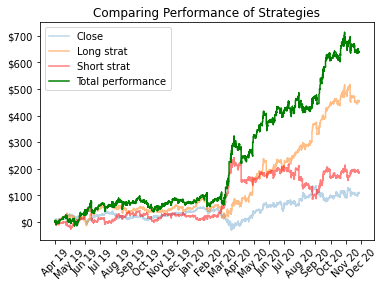

In [17]:
performance_hold = df['close'].iloc[-1] - df['close'].iloc[1]
performance_long = df['long_pnl'].cumsum().fillna(method='ffill')
performance_short = df['short_pnl'].cumsum().fillna(method='ffill')
total_performance = df['total_pnl'].cumsum().fillna(method='ffill')

print(f"Profit from hold strategy: {performance_hold}")
print(f"Profit from short strategy: {(df['short_pnl'].sum())}")
print(f"Profit from long strategy: {df['long_pnl'].sum()}")
print(f"Profit from long & short strategies: {(df['total_pnl'].sum())}")
print(f"Max long draw down: {performance_long.min()}")
print(f"Max short draw down: {performance_short.min()}")
print(f"Max total draw down: {total_performance.min()}")

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b %y')

plt.plot(df['date'], df['close']-df['close'][0], alpha=0.3) #Performance of holding stock in the same time period
plt.plot(df['date'], performance_long, alpha=0.5)
plt.plot(df['date'], performance_short, alpha=0.5, color='red')
plt.plot(df['date'], total_performance, color='green')
x = plt.gca()
y = plt.gca()
x.xaxis.set_major_locator(locator)
x.xaxis.set_major_formatter(fmt)
y.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45)
plt.title('Comparing Performance of Strategies')
plt.legend(['Close', 'Long strat', 'Short strat', 'Total performance'])
plt.show()


Labeling each trade performance  
* 1 for profitable trades
* 0 for losses

In [18]:
df['long_labels'] = np.where(df['long_pnl'] <= 0, 0,
                        np.where(df['long_pnl'] > 0, 1, np.nan))

df['short_labels'] = np.where(df['short_pnl'] <= 0, 0, 
                        np.where(df['short_pnl'] > 0, 1, np.nan))

Strategy yielded more winning trades than losing

Both long and short conditions made roughly the same amount of profitable trades against losing trades

In [19]:
print(df['long_labels'].value_counts())
print(df['short_labels'].value_counts())

1.0    9931
0.0    5661
Name: long_labels, dtype: int64
1.0    9690
0.0    5939
Name: short_labels, dtype: int64


Export data to csv

In [20]:
df.to_csv('fb_rsi.csv', index=False)

# Conclusion
Strategy trades very often and holds trade for a short time frame  
Strategy made about twice as much winning trades against lossing trades, next step is to try optimizing the strategy to reduce lossing trade with deep learning models  

## Strategy's limiation:
* Strategy only buys or sells 1 stock during each trade, strategy could be scaled up based on account size
* No stop-loss feature to limit loses in losing trades

## To-do list:
* Add risk management feature, perhaps kelly criterion to allocate bet size
* Add stop-loss feature, limit amount on losing trades